# MLD Data Processing

| Property               | observations and model                   | 
|------------------------|------------------------------------------|
| **Content**            | `mld`                                    |
| **Resolution**         | `1.0°`                                   |
| **Mask**               | `Yes (NaN)`                              | 
| **Time**               | `monthly climatology`                    |
| **Time fromat**        | `month (1, 2, ...)`                      |
| **Dimensions**         | `time`, `lat`, `lon`                     |
| **Dimension lon/lat**  | `1D`                                     |
| **Name time**          | `time`                                   |
| **Longitude range**    | `0.50° to 359.50° (west to east) `       |
| **Latitude range**     | `89.50° to -89.50°` (north to south)     |

## Imports

In [1]:
import xarray as xr
import numpy as np
from data_utils import fill_coastal_points_in_time
import regionmask
import contextlib, os, sys
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Data processing

In [2]:
obs = xr.open_dataset('../data/observations/mld_dr003_ref10m_v2023.nc')
model = xr.open_dataset('../data/model/nemo00_1m_201001_202212_grid_T.nc')
mesh = xr.open_dataset('../data/model/orca05l75_domain_cfg_nemov5_10m.nc')

### Extracting mld

In [3]:
obs = obs['mld_dr003']
model = model['mldr10_1']

### Renaming

In [4]:
model = model.rename({
    'nav_lon': 'lon',
    'nav_lat': 'lat',
    'time_counter': 'time'
})

times = model.time.values.astype('datetime64[M]')  # truncate to month start
model['time'] = times
model = model.assign_coords(lon=mesh['glamt'], lat=mesh['gphit'])

### Filling coastal points and regridding (interpolation): model -> obs

In [5]:
land_mask = mesh['bathy_metry'] == 0
model = model.where(~land_mask)
filled_model = fill_coastal_points_in_time(model, 20)

import xesmf as xe

target_grid = xr.Dataset({
    'lon': (['lon'], np.arange(-179.5, 179.5 + 1)),  
    'lat': (['lat'], np.arange(-89.5, 89.5 + 1))     
})

with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
    regridder = xe.Regridder(
        filled_model, target_grid,
        method='bilinear',
        filename='weights_bilinear.nc',  
        reuse_weights=True,                  
        ignore_degenerate=True,
        periodic=True
    )

model_regridded = regridder(model)

### -180 to 180 -> 0 to 360 *and* -89.5 to 89.5 -> 89.5 to -89.5 *and* dimension ordering

In [6]:
model_regridded['lon'] = (model_regridded['lon'] + 360) % 360
model_regridded = model_regridded.sortby('lon') 
model_regridded = model_regridded.sortby('lat', ascending=False)
model_regridded = model_regridded.transpose('time', 'lat', 'lon')

obs['lon'] = (obs['lon'] + 360) % 360
obs = obs.sortby('lon') 
obs = obs.sortby('lat', ascending=False)
obs = obs.transpose('time', 'lat', 'lon')

### Monthly Climatology

In [7]:
model_regridded = model_regridded.groupby('time.month').mean(dim='time')

### Naming coordinates and attributes

In [8]:
model_regridded.coords['lon'].attrs.update({
    'long_name': 'Longitude',
    'units': 'degrees_east',
    'standard_name': 'longitude'
})

model_regridded.coords['lat'].attrs.update({
    'long_name': 'Latitude',
    'units': 'degrees_north',
    'standard_name': 'latitude'
})

obs.coords['lon'].attrs.update({
    'long_name': 'Longitude',
    'units': 'degrees_east',
    'standard_name': 'longitude'
})

obs.coords['lat'].attrs.update({
    'long_name': 'Latitude',
    'units': 'degrees_north',
    'standard_name': 'latitude'
})

model_regridded.attrs.update({
    'long_name': 'Monthly Climatology of Mixed Layer Depth (mldr10_1)',
    'units': 'm',
    'standard_name': 'ocean_mixed_layer_thickness'
})

obs.attrs.update({
    'long_name': 'Monthly Climatology of Mixed Layer Depth (mld_dr003)',
    'units': 'm',
    'standard_name': 'ocean_mixed_layer_thickness'
})

day_of_year = obs['time'].values  # e.g., [14, 45, ..., 348]
ref_dates = np.array(['2001-01-01'], dtype='datetime64[D]') + day_of_year.astype('timedelta64[D]')
months = xr.DataArray(ref_dates.astype('datetime64[M]').astype(int) % 12 + 1, dims='time', name='month')
obs = obs.assign_coords(month=months).swap_dims({'time': 'month'}).drop_vars('time')

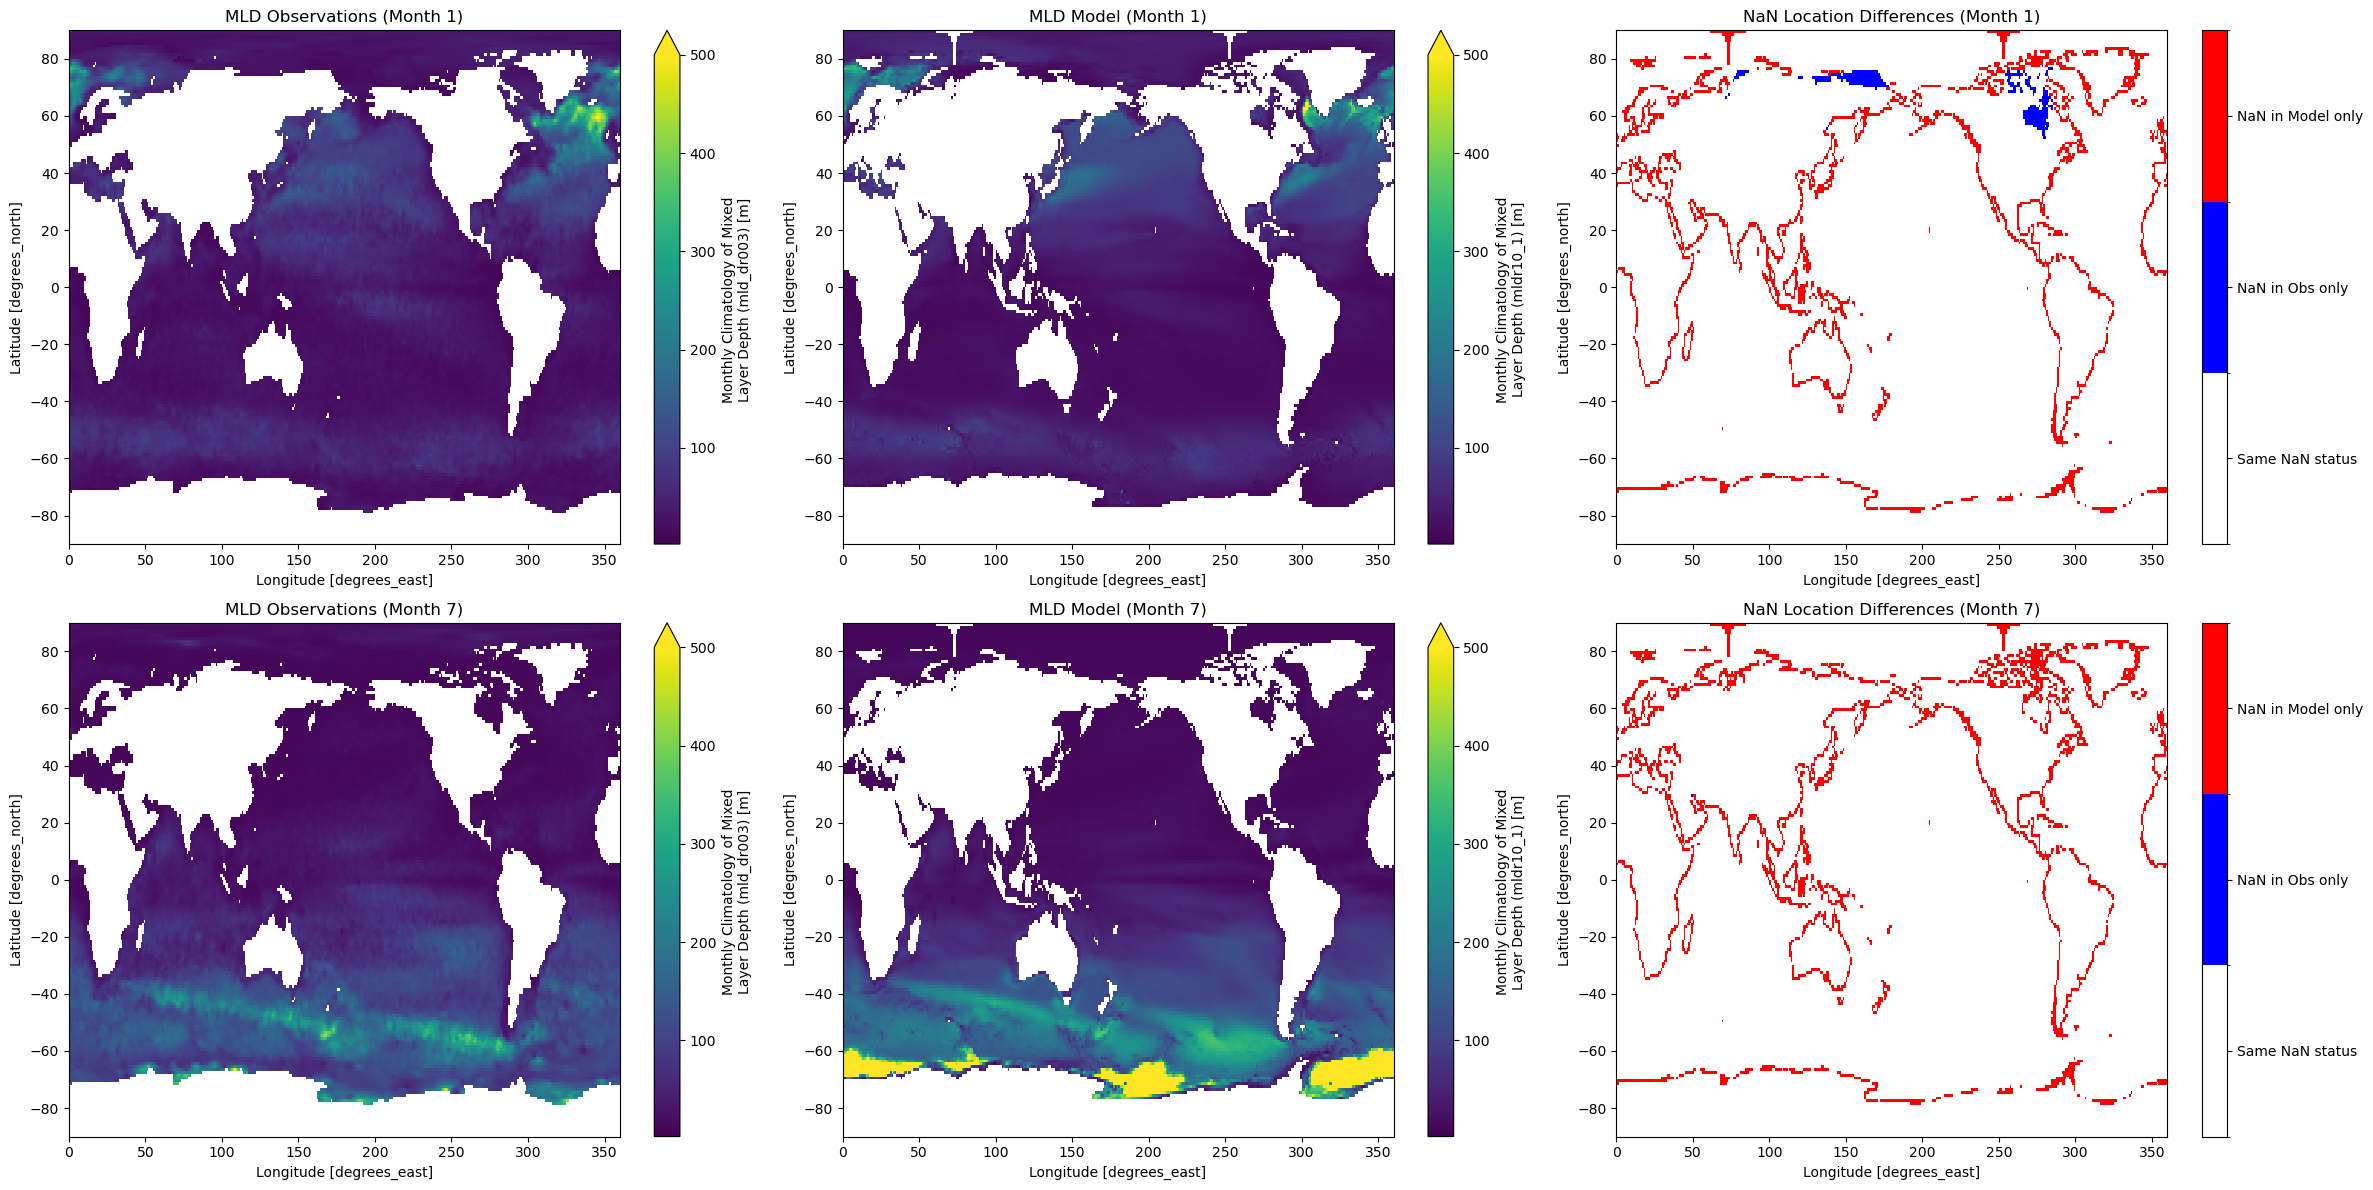

In [9]:
months = [1, 7]  

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 12))

# Custom colormap and normalization
cmap = mcolors.ListedColormap(['white', 'blue', 'red'])
bounds = [-0.5, 0.5, 1.5, 2.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

for i, month in enumerate(months):
    # Plot original fields
    obs.sel(month=month).plot(ax=axes[i, 0], vmin=2, vmax=500)
    axes[i, 0].set_title(f'MLD Observations (Month {month})')

    model_regridded.sel(month=month).plot(ax=axes[i, 1], vmin=2, vmax=500)
    axes[i, 1].set_title(f'MLD Model (Month {month})')

    # NaN masks
    obs_nan = obs.sel(month=month).isnull()
    model_nan = model_regridded.sel(month=month).isnull()

    # Difference map
    nan_diff = xr.full_like(obs_nan, 0, dtype=int)
    nan_diff = nan_diff.where(obs_nan == model_nan, 1)
    nan_diff = nan_diff.where(~((~obs_nan) & model_nan), 2)
    nan_diff = nan_diff.where(obs_nan == model_nan, nan_diff)

    # Plot NaN difference
    im = nan_diff.plot(ax=axes[i, 2], cmap=cmap, norm=norm, add_colorbar=False)
    cbar = plt.colorbar(im, ax=axes[i, 2], ticks=[0, 1, 2])
    cbar.ax.set_yticklabels([
        'Same NaN status',
        'NaN in Obs only',
        'NaN in Model only'
    ])
    axes[i, 2].set_title(f'NaN Location Differences (Month {month})')

plt.tight_layout()

### Masking the continents

In [10]:
land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(model_regridded)
ocean_mask = land_mask.isnull()
model_regridded = model_regridded.where(ocean_mask) 
obs = obs.where(ocean_mask) 

### Plotting

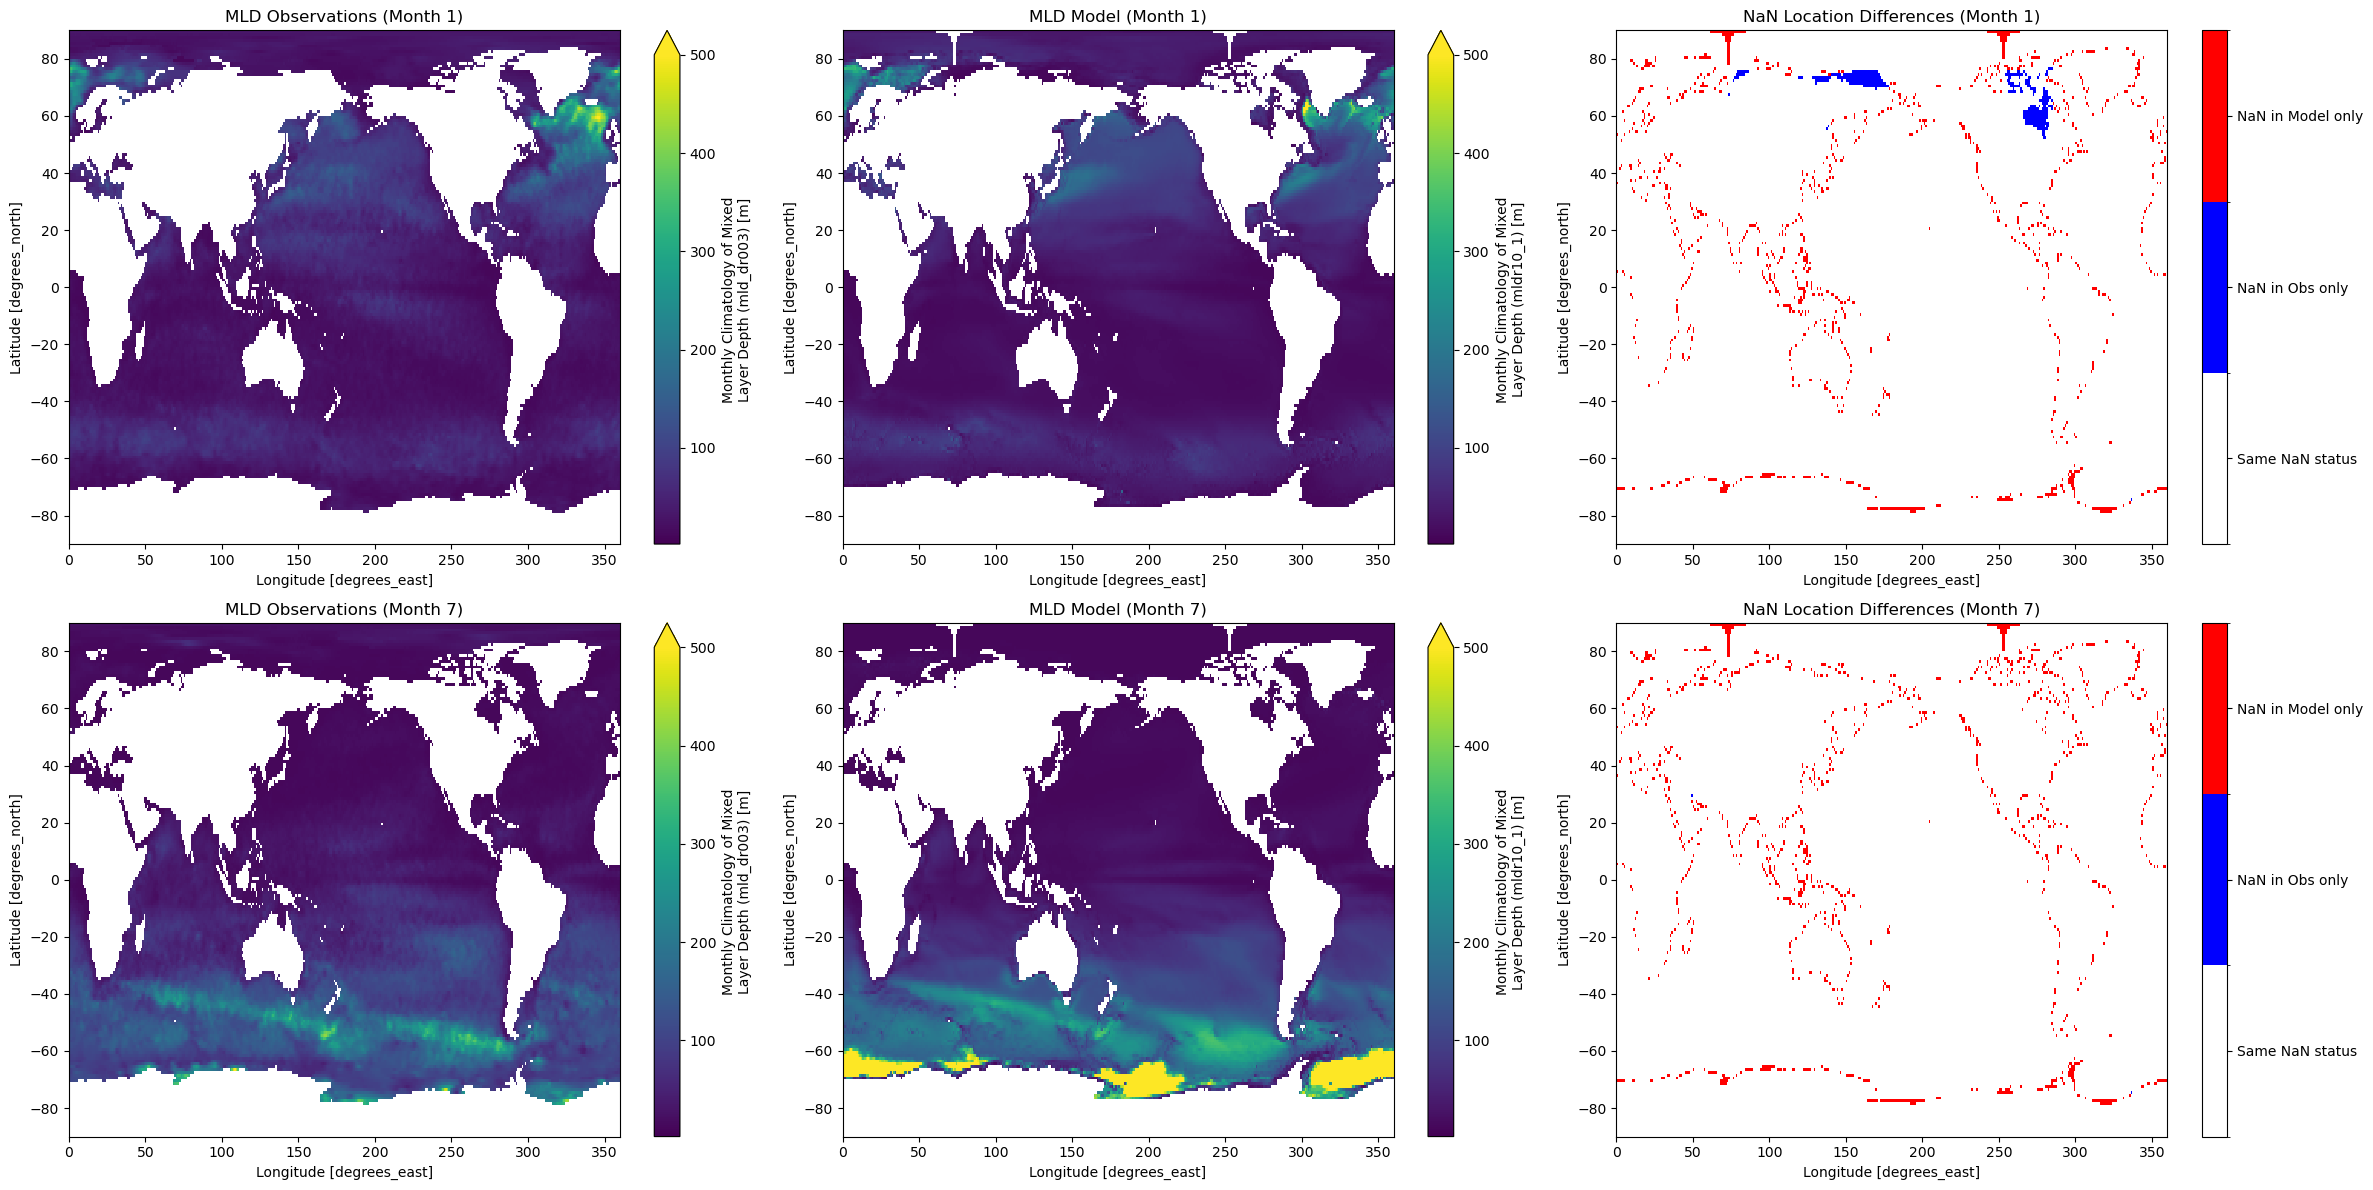

In [11]:
months = [1, 7]  

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 12))

# Custom colormap and normalization
cmap = mcolors.ListedColormap(['white', 'blue', 'red'])
bounds = [-0.5, 0.5, 1.5, 2.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

for i, month in enumerate(months):
    # Plot original fields
    obs.sel(month=month).plot(ax=axes[i, 0], vmin=2, vmax=500)
    axes[i, 0].set_title(f'MLD Observations (Month {month})')

    model_regridded.sel(month=month).plot(ax=axes[i, 1], vmin=2, vmax=500)
    axes[i, 1].set_title(f'MLD Model (Month {month})')

    # NaN masks
    obs_nan = obs.sel(month=month).isnull()
    model_nan = model_regridded.sel(month=month).isnull()

    # Difference map
    nan_diff = xr.full_like(obs_nan, 0, dtype=int)
    nan_diff = nan_diff.where(obs_nan == model_nan, 1)
    nan_diff = nan_diff.where(~((~obs_nan) & model_nan), 2)
    nan_diff = nan_diff.where(obs_nan == model_nan, nan_diff)

    # Plot NaN difference
    im = nan_diff.plot(ax=axes[i, 2], cmap=cmap, norm=norm, add_colorbar=False)
    cbar = plt.colorbar(im, ax=axes[i, 2], ticks=[0, 1, 2])
    cbar.ax.set_yticklabels([
        'Same NaN status',
        'NaN in Obs only',
        'NaN in Model only'
    ])
    axes[i, 2].set_title(f'NaN Location Differences (Month {month})')

plt.tight_layout()

### Saving in a file

In [12]:
model_regridded.to_netcdf('../data/processed/nemo00_mld_monthly_climatology.nc', mode='w')
obs.to_netcdf('../data/processed/observations_mld_monthly_climatology.nc', mode='w')